<a href="https://colab.research.google.com/github/Achillesy/Fetal_Brain_GA_Prediction/blob/master/fmri_ga_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gestational Age Prediction of Fetal Brain Magnetic Resonance Imaging Using Head Circumference

## Preprocessing, downloading resources from my github repository

https://github.com/Achillesy/Fetal_Brain_GA_Prediction
![xuchu](https://avatars.githubusercontent.com/u/5572441?s=16)

In [ ]:
!wget https://github.com/Achillesy/Fetal_Functional_MRI_Segmentation/releases/download/v1.0.0/fold4_train_metric_vnet.pth

## Install ![monai](https://monai.io/assets/img/MONAI-logo_color.png) and check environment variables

In [ ]:
!pip install monai

from monai.config import print_config
print_config()


In [3]:
import os
import numpy as np
import nibabel as nib
from glob import glob

import torch
from types import SimpleNamespace
# from google.colab import files

cfg = SimpleNamespace(**{})
cfg.pixdim = (3.5, 3.5, 3.5)
cfg.roi_size = [64, 64, 64]
cfg.sw_batch_size = 4
cfg.file_pth = "fold4_train_metric_vnet.pth"

cfg.mri_dir = "mri"
cfg.mask_dir = "mask"
os.makedirs(cfg.mri_dir, exist_ok=True)
os.makedirs(cfg.mask_dir, exist_ok=True)

cfg.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Load VNet model and parameters

In [4]:
from monai.networks.nets import VNet

model = VNet(
  spatial_dims=3,
  in_channels=1,
  out_channels=2,
  act=("elu", {"inplace": True}),
  dropout_dim=3,
  bias=False,
).to(cfg.device)
model.load_state_dict(torch.load(cfg.file_pth, cfg.device))


<All keys matched successfully>

In [5]:
from monai.transforms import (
  AsDiscreted,
  Compose,
  EnsureChannelFirstd,
  Invertd,
  LoadImaged,
  NormalizeIntensityd,
  Orientationd,
  SaveImaged,
  Spacingd,
)

test_transforms = Compose(
  [
    LoadImaged(keys=["image"], image_only=True),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=cfg.pixdim, mode="bilinear"),
    NormalizeIntensityd(keys="image", nonzero=True),
  ]
)

post_transforms = Compose(
  [
    AsDiscreted(keys="pred", argmax=True),
  ]
)

## Please upload your Fetal Functional MRI files

![upload_guide](https://github.com/Achillesy/Fetal_Functional_MRI_Segmentation/blob/master/figures/upload_guide.png?raw=1)

1. Click the **Files** icon on the left
2. Click the **Upload to session storage** icon above
3. Your uploaded files will be displayed here

----
After double-checking your uploaded files, by <font color="green">pressing the **Enter** key in the input box below</font>, the fMRI mask will be automatically generated in a short time.

In [6]:
input()


''

## Split into multiple 3D MRI files

In [7]:
frmi_files = glob("*.nii.gz")
for fmri_data in frmi_files:
  fmri_data_name = os.path.basename(fmri_data).replace(".nii.gz", "")
  image = nib.load(fmri_data)
  data = image.get_fdata()
  if len(data.shape) != 4:
    raise ValueError("Invalid shape of fMRI file format. Expected 4D shape: [x, y, z, t]")
  channel_list = np.split(data, data.shape[-1], axis=-1)
  for i, channel in enumerate(channel_list):
    channel_image = nib.Nifti1Image(channel, image.affine)
    channel_file_name = os.path.join(cfg.mri_dir, f"{fmri_data_name}_{i+1}.nii.gz")
    nib.save(channel_image, channel_file_name)


In [ ]:
test_files = []
rmi_files = glob(os.path.join(cfg.mri_dir, "*.nii.gz"))
for f_file in rmi_files:
  test_files.append({"image": f_file})
# print(test_files)


## Generate MRI Mask and Predict Gestational Age

In [9]:
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, Dataset, decollate_batch

test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)


### Obtain GA correlation coefficients FOP, BPD, HC

Before making GA predictions, please make sure that the default orientation of the fMRI you upload is correct after MONAI conversion:
``` python
  Orientationd(keys=["image"], axcodes="RAS"),
  Spacingd(keys=["image"], pixdim=cfg.pixdim, mode="bilinear")

```
The direction is adjusted to RAS, and the pixdim is adjusted to (3.5,3.5,3.5

Otherwise, open the debug code section and check the output image..


In [10]:
import cv2

def get_GA_Coefficinet(mask_data):
  mask_data[mask_data != 0] = 1
  sum_z_mask = np.sum(mask_data, axis=(0, 1))
  z_index = np.argmax(sum_z_mask)
  ax_mask = mask_data[:, :, z_index]
  # ax_img  = img_data[:, :, z_index]
  contours, _ = cv2.findContours(ax_mask.astype("uint8"), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  max_area = 0
  for contour in contours:
    area = cv2.contourArea(contour)
    if area > max_area:
      max_area = area
      max_contour = contour
  hull = cv2.convexHull(max_contour)
  perimeter = cv2.arcLength(hull, True)
  rect = cv2.minAreaRect(max_contour)
  fod = max(rect[1])
  bpd = min(rect[1])
  return z_index, fod, bpd, perimeter

### Replace it with your favorite GA prediction formula

In [11]:
def get_GA_HC(hc):
    hc = (hc + 7) / 10
    ga = 0.0185 * hc * hc + 0.1713 * hc + 11.184
    return ga

### Traverse all 3D volumes in fMRI and predict GA by each axial section

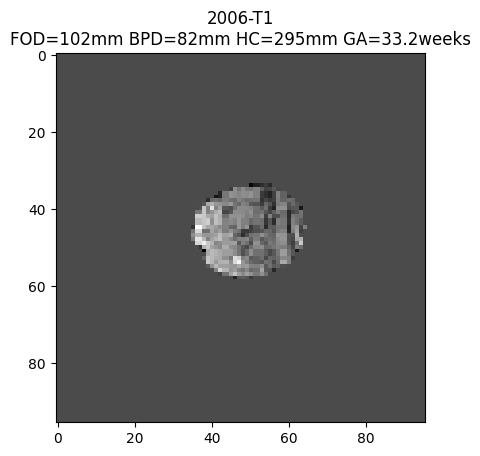

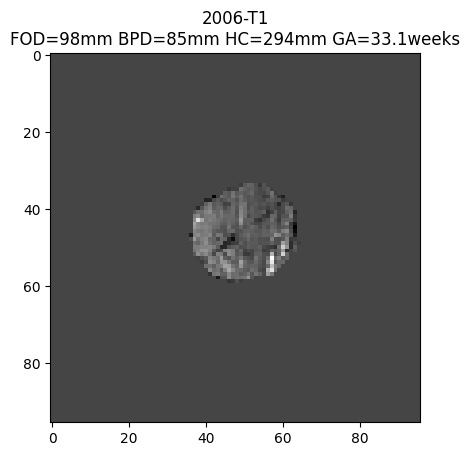

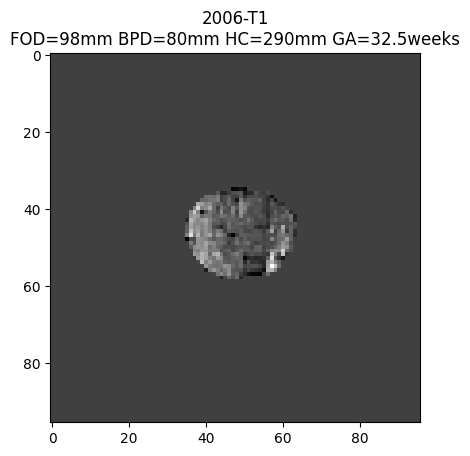

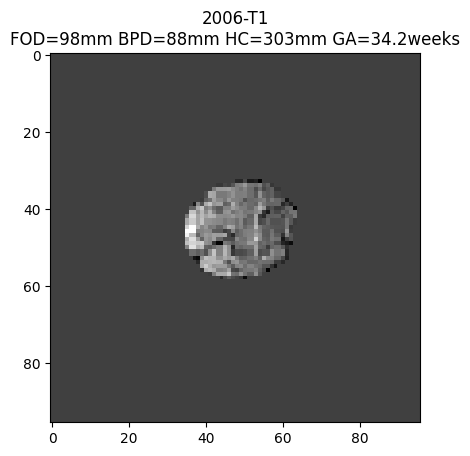

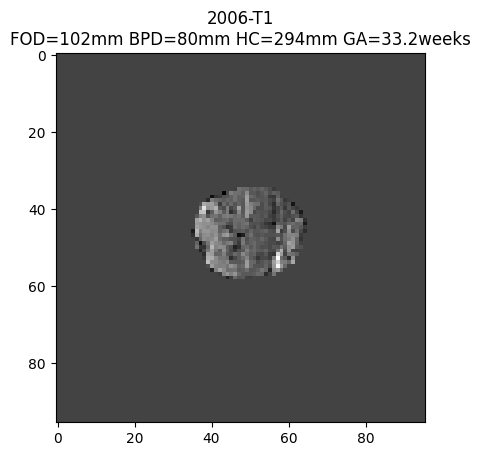

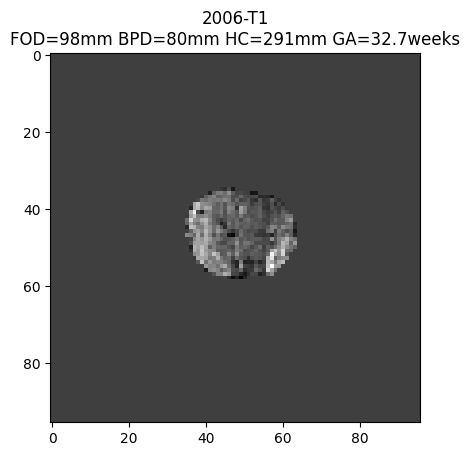

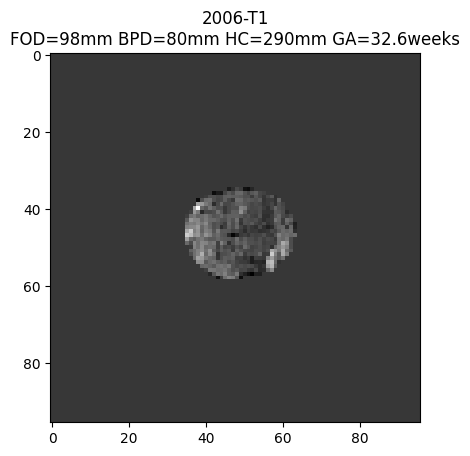

In [31]:
import re
import matplotlib.pyplot as plt

normal_list = []
with torch.no_grad():
  for i, test_data in enumerate(test_loader):
    ax_dict = {}
    test_inputs = test_data["image"].to(cfg.device)
    test_data["pred"] = sliding_window_inference(
      test_inputs, cfg.roi_size, cfg.sw_batch_size, model
    )
    test_data = [post_transforms(i) for i in decollate_batch(test_data)]
    z_index, fod, bpd, perimeter = get_GA_Coefficinet(test_data[0]['pred'][0].cpu().numpy())
    fmri_name = os.path.basename(test_files[0]['image'])
    pattern = r"_(\d+)\.nii\.gz"
    ax_dict['FileName'] = re.sub(pattern, '', fmri_name)
    ax_dict['pixdim'] = 3.5
    ax_dict['Slice'] = z_index
    ax_dict['FOD']  = round(ax_dict['pixdim'] * fod, 1)
    ax_dict['BPD']  = round(ax_dict['pixdim'] * bpd, 1)
    ax_dict['HC']  = round(ax_dict['pixdim'] * perimeter, 1)
    ax_dict['GA'] = get_GA_HC(ax_dict['HC'])
    normal_list.append(ax_dict)

    # Debug
    # ax_image = test_data[0]['image'][0].cpu().numpy()[..., z_index]
    # ax_mask =  test_data[0]['pred'][0].cpu().numpy()[..., z_index]

    # plt.imshow(ax_image * ax_mask, cmap="gray")
    # plt.title(f"{ax_dict['FileName']}\nFOD={ax_dict['FOD']:.0f}mm BPD={ax_dict['BPD']:.0f}mm HC={ax_dict['HC']:.0f}mm GA={ax_dict['GA']:.1f}weeks")
    # plt.show()


In [32]:
import pandas as pd

normal_df = pd.DataFrame.from_dict(normal_list)
grouped = normal_df.groupby('FileName')
for key, group in grouped:
  print(key, end=": ")
  median_ga = group['GA'].median()
  week = int(median_ga)
  day = int((median_ga - week) * 7)
  print(f"{week} weeks {day} days")

# Debug
# display(normal_df)

2006-T1: 33 weeks 0 days


,FileName,pixdim,Slice,FOD,BPD,HC,GA
0,2006-T1,3.5,50,101.6,82.4,295.0,33.230000
1,2006-T1,3.5,48,97.6,84.9,294.2,33.127022
2,2006-T1,3.5,49,98.0,80.5,289.5,32.526811
3,2006-T1,3.5,49,98.0,87.5,302.8,34.246441
4,2006-T1,3.5,49,101.5,80.5,294.5,33.165611
5,2006-T1,3.5,49,98.0,80.5,290.6,32.666554
6,2006-T1,3.5,50,98.0,80.5,290.1,32.602979


## Clean up temporary files

In [30]:
!rm -rf {cfg.mask_dir}
